In [1]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil

import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
from sklearn.utils import shuffle
import tensorflow as tf

seed=19
np.random.seed(seed)
python_random.seed(seed)

In [ ]:

dataset_path="./DataSet/"
os.makedirs(dataset_path, exist_ok=True)

In [4]:
chexpert_meta_data = pd.read_csv(dataset_path+'train_visualCheXbert.csv')

In [5]:
chexpert_meta_data.head(2)

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
chexpert_meta_data['path_splited'] = chexpert_meta_data['Path'].str.split('/')
chexpert_meta_data['patientid'] = chexpert_meta_data['path_splited'].apply(lambda x: x[2])

# Insert 'patient_id' column at the second position
chexpert_meta_data.insert(1, 'patient_id', chexpert_meta_data['patientid'])

# Drop the intermediate 'path_splited' column
chexpert_meta_data.drop('path_splited', axis=1, inplace=True)
chexpert_meta_data.drop('patientid', axis=1, inplace=True)


In [7]:
chexpert_meta_data.head(2)

,Path,patient_id,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,patient00001,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,patient00002,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
chexpert_demo= pd.read_excel(dataset_path+'CHEXPERT DEMO.xlsx')

In [9]:
# merge chexpert_meta_data with chexpert_demo
merged_chexpert_df = pd.merge(chexpert_meta_data, chexpert_demo, left_on='patient_id', right_on='PATIENT', how='inner')


In [10]:
merged_chexpert_df.shape

(222561, 25)

In [11]:
# Define the desired order of columns
desired_columns_order = ['Path', 'patient_id', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'PATIENT','GENDER',
                         'PRIMARY_RACE','ETHNICITY','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
                         'Lung Lesion', 'Edema','Consolidation', 'Pneumonia','Atelectasis','Pneumothorax',
                         'Pleural Effusion', 'Pleural Other','Fracture', 'Support Devices','No Finding'
                         ]
# Reorder the columns in the merged DataFrame
reordered_CXP_df = merged_chexpert_df[desired_columns_order]

In [12]:
reordered_CXP_df['Age'] = reordered_CXP_df['Age'].astype('int64')

reordered_CXP_df.insert(reordered_CXP_df.columns.get_loc('Age') + 1, 'age_decile', None)

# Define custom bin edges and labels
bin_edges = [0, 20, 40, 60, 80, float('inf')]
bin_labels = ['0-20', '20-40', '40-60', '60-80', '80+']

# Use cut to create age deciles based on custom bins
reordered_CXP_df['age_decile'] = pd.cut(reordered_CXP_df['Age'],
                                    bins=bin_edges, labels=bin_labels,
                                    right=False)
display(reordered_CXP_df.head(2))

C:\Users\gebre\AppData\Local\Temp\ipykernel_4884\2661509669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reordered_CXP_df['Age'] = reordered_CXP_df['Age'].astype('int64')


,Path,patient_id,Sex,Age,age_decile,Frontal/Lateral,AP/PA,PATIENT,GENDER,PRIMARY_RACE,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,patient00001,Female,68,60-80,Frontal,AP,patient00001,Female,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,patient00002,Female,87,80+,Frontal,AP,patient00002,Female,"White, non-Hispanic",...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
reordered_CXP_df.shape

(222561, 25)

In [14]:
reordered_CXP_df.PRIMARY_RACE.value_counts()

PRIMARY_RACE
White                                        102402
Other                                         28095
White, non-Hispanic                           22154
Asian                                         20434
Unknown                                       15186
Black or African American                      9909
Race and Ethnicity Unknown                     8716
Other, Hispanic                                3621
Native Hawaiian or Other Pacific Islander      2809
Asian, non-Hispanic                            2793
Black, non-Hispanic                            2000
White, Hispanic                                 922
Other, non-Hispanic                             566
American Indian or Alaska Native                457
Patient Refused                                 405
Pacific Islander, non-Hispanic                  337
Native American, non-Hispanic                    55
Black, Hispanic                                  52
Asian, Hispanic                                  37

In [16]:
race_mapping = {
    'White': 'WHITE',
    'White, non-Hispanic': 'WHITE',
    'White or Caucasian': 'WHITE',
    'Black or African American': 'BLACK/AFRICAN AMERICAN',
    'Black, non-Hispanic': 'BLACK/AFRICAN AMERICAN',
    'Other':'OTHER',
    'Other, non-Hispanic':'OTHER',
    'Black, Hispanic':'HISPANIC/LATINO',
    'White, Hispanic':'HISPANIC/LATINO',
    'Other, Hispanic':'HISPANIC/LATINO',
    'Pacific Islander, Hispanic':'HISPANIC/LATINO',
    'Native American, Hispanic':'HISPANIC/LATINO',
    'Asian':'ASIAN',
    'Asian, Hispanic':'ASIAN',
    'Asian - Historical Conv':'ASIAN',
    'Asian, non-Hispanic':'ASIAN',
    'Native Hawaiian or Other Pacific Islander':'AMERICAN INDIAN/ALASKA NATIVE',
    'American Indian or Alaska Native':'AMERICAN INDIAN/ALASKA NATIVE',
    'Pacific Islander, non-Hispanic':'AMERICAN INDIAN/ALASKA NATIVE',
    'Native American, non-Hispanic':'AMERICAN INDIAN/ALASKA NATIVE'
}

In [17]:
# Apply the mapping to create a new column 'Race'
reordered_CXP_df['Race'] = reordered_CXP_df['PRIMARY_RACE'].map(race_mapping)

In [18]:
# Check the value counts of the race now
print(reordered_CXP_df['Race'].value_counts())

Race
WHITE                            124569
OTHER                             28661
ASIAN                             23272
BLACK/AFRICAN AMERICAN            11909
HISPANIC/LATINO                    4630
AMERICAN INDIAN/ALASKA NATIVE      3658
Name: count, dtype: int64


In [19]:
reordered_CXP_df = reordered_CXP_df.drop(columns=['ETHNICITY','Age','Frontal/Lateral','AP/PA','PRIMARY_RACE'], axis=1)

In [20]:
reordered_CXP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222561 entries, 0 to 222560
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Path                        222561 non-null  object  
 1   patient_id                  222561 non-null  object  
 2   Sex                         222561 non-null  object  
 3   age_decile                  222561 non-null  category
 4   PATIENT                     222561 non-null  object  
 5   GENDER                      222561 non-null  object  
 6   Enlarged Cardiomediastinum  222561 non-null  float64 
 7   Cardiomegaly                222561 non-null  float64 
 8   Lung Opacity                222561 non-null  float64 
 9   Lung Lesion                 222561 non-null  float64 
 10  Edema                       222561 non-null  float64 
 11  Consolidation               222561 non-null  float64 
 12  Pneumonia                   222561 non-null  float64 
 13 

In [21]:
reordered_CXP_df.rename(columns={'Path':'path'},inplace=True)

In [22]:
# Path to the extracted npz files
train_file_path = os.path.join(dataset_path, 'train.npz')


In [23]:
# Load the datasets
chexpert_dataset = np.load(train_file_path, allow_pickle=True)

In [24]:
print(f'Length of train dataset : {len(chexpert_dataset)}')

Length of train dataset : 223414


In [25]:
for key in chexpert_dataset.keys():
  print(key,chexpert_dataset[key])
  break


CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg [-0.64997774 -2.12270832  0.84318995 ... -0.29365113  0.3868877
 -0.38179815]


In [26]:
# # Convert train_dataset to a Pandas DataFrame for efficient merging
train_df = pd.DataFrame(list(chexpert_dataset.items()), columns=['path', 'features'])

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   path      223414 non-null  object
 1   features  223414 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [30]:
print(len(train_df.features[0]))
print(train_df.features[0])

1376
[-0.64997774 -2.12270832  0.84318995 ... -0.29365113  0.3868877
 -0.38179815]


In [27]:
# Merge metadata with train_dataset
cxp_df = pd.merge(reordered_CXP_df, train_df, on='path', how='inner')

In [28]:
cxp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222561 entries, 0 to 222560
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   path                        222561 non-null  object  
 1   patient_id                  222561 non-null  object  
 2   Sex                         222561 non-null  object  
 3   age_decile                  222561 non-null  category
 4   PATIENT                     222561 non-null  object  
 5   GENDER                      222561 non-null  object  
 6   Enlarged Cardiomediastinum  222561 non-null  float64 
 7   Cardiomegaly                222561 non-null  float64 
 8   Lung Opacity                222561 non-null  float64 
 9   Lung Lesion                 222561 non-null  float64 
 10  Edema                       222561 non-null  float64 
 11  Consolidation               222561 non-null  float64 
 12  Pneumonia                   222561 non-null  float64 
 13 

In [29]:
# Define the desired order of columns
desired_columns_order = ['path', 'patient_id', 'Sex', 'age_decile', 'PATIENT','GENDER',
                         'Race','features','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
                         'Lung Lesion', 'Edema','Consolidation', 'Pneumonia','Atelectasis','Pneumothorax',
                         'Pleural Effusion', 'Pleural Other','Fracture', 'Support Devices','No Finding'
                         ]
# Reorder the columns in the merged DataFrame
cxp_df = cxp_df[desired_columns_order]

In [30]:
cxp_df.rename(columns={'GENDER':'gender','Race':'race'},inplace=True)

In [31]:
cxp_df.drop(columns=['Sex'],inplace=True)

In [32]:

# cxp_df.rename(columns={'patient_id':'PATIENT'},inplace=True)



In [33]:
cxp_df=cxp_df[cxp_df['gender'] != 'Unknown']

In [34]:
cxp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222560 entries, 0 to 222560
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   path                        222560 non-null  object  
 1   patient_id                  222560 non-null  object  
 2   age_decile                  222560 non-null  category
 3   PATIENT                     222560 non-null  object  
 4   gender                      222560 non-null  object  
 5   race                        196699 non-null  object  
 6   features                    222560 non-null  object  
 7   Enlarged Cardiomediastinum  222560 non-null  float64 
 8   Cardiomegaly                222560 non-null  float64 
 9   Lung Opacity                222560 non-null  float64 
 10  Lung Lesion                 222560 non-null  float64 
 11  Edema                       222560 non-null  float64 
 12  Consolidation               222560 non-null  float64 
 13  Pneu

In [35]:
unique_pathId = cxp_df.PATIENT.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_path_id = shuffle(unique_pathId)
value1 = (round(len(unique_path_id)*train_percent))
value2 = (round(len(unique_path_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_path_id)*test_percent))

In [36]:
print("Patients in training set: " + str(value1))

Patients in training set: 51383


In [37]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 6423


In [38]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 6423


In [39]:
data_df = shuffle(cxp_df)

train_path_id = unique_path_id[:value1]
validate_path_id = unique_path_id[value1:value3]
test_path_id = unique_path_id[value3:]

print(type(train_path_id))
print(train_path_id)

<class 'numpy.ndarray'>
['patient21555' 'patient25100' 'patient62713' ... 'patient18602'
 'patient58251' 'patient23028']


In [40]:
data_df.insert(7, "split","none", True)

In [41]:
data_df.rename(columns={'patient_id':'subject id'},inplace=True)

In [42]:
data_df.path[0]

'CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg'

In [43]:
# data_df.to_csv("D:/Academics/Master/Thesis/CheXpert_Emb/CheXpert_Preprocessed.csv")

data_df['path'] = data_df['path'].str.replace(r'^CheXpert-v1.0/', '', regex=True)

In [44]:
data_df['path'] = data_df['path'].str.replace('.jpg', '')

In [45]:
data_df.head(2)

,path,subject id,age_decile,PATIENT,gender,race,features,split,Enlarged Cardiomediastinum,Cardiomegaly,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
111127,train/patient26731/study3/view1_frontal,patient26731,40-60,patient26731,Female,WHITE,"[-0.223833829164505, -1.6410856246948242, 0.21...",none,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
167206,train/patient39150/study1/view1_frontal,patient39150,80+,patient39150,Male,WHITE,"[0.43689048290252686, -1.9892404079437256, 0.6...",none,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
data_df.loc[data_df.PATIENT.isin(train_path_id), "split"]="train"
data_df.loc[data_df.PATIENT.isin(validate_path_id), "split"]="validate"
data_df.loc[data_df.PATIENT.isin(test_path_id), "split"]="test"

data_df['gender']=data_df['gender'].replace({'Male':'M','Female':'F'})

In [47]:
data_df.split.value_counts()

split
train       178402
test         22085
validate     22073
Name: count, dtype: int64

In [48]:
df_train = data_df[data_df["split"] == "train"]
df_train.head(2)
df_train.to_csv(dataset_path+"cxp_train_df.csv",index=False)

In [49]:
data_df.gender.value_counts()

gender
M    132089
F     90471
Name: count, dtype: int64

In [50]:
df_validate = data_df[data_df["split"] == "validate"]
df_validate.head(2)
df_validate.to_csv(dataset_path+"cxp_validation_df.csv",index=False)

In [51]:

df_test = data_df[data_df["split"] == "test"]
df_test = df_test.dropna(subset=['race']).reset_index(drop=True)
df_test.shape
df_test.to_csv(dataset_path+"cxp_test_df.csv",index=False)

In [52]:
data_df=pd.concat([df_train,df_validate,df_test],axis=0)

In [53]:
data_df.shape

(219946, 22)

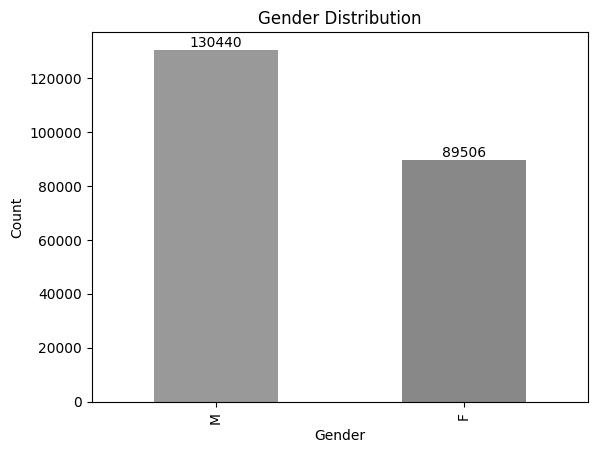

In [54]:
# Count the occurrences of each gender
gender_counts = data_df.gender.value_counts()

# Create a bar plot with labels
fig, ax = plt.subplots()
gender_counts.plot(kind='bar', color=['#999999', '#888888', '#777777', '#666666', '#555555', '#444444', '#333333'], ax=ax)

# Add labels
for i, v in enumerate(gender_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()


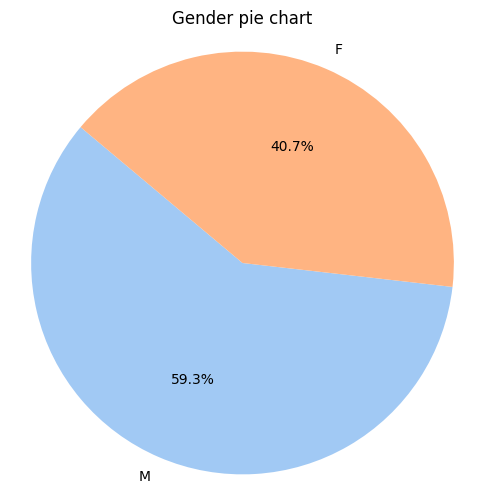

In [55]:
# Count the occurrences of each race
gender_counts = data_df.gender.value_counts()

# Define a Seaborn color palette with muted colors
sns.set_palette("pastel")

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender pie chart')

# Show the pie chart
plt.axis('equal')
plt.show()

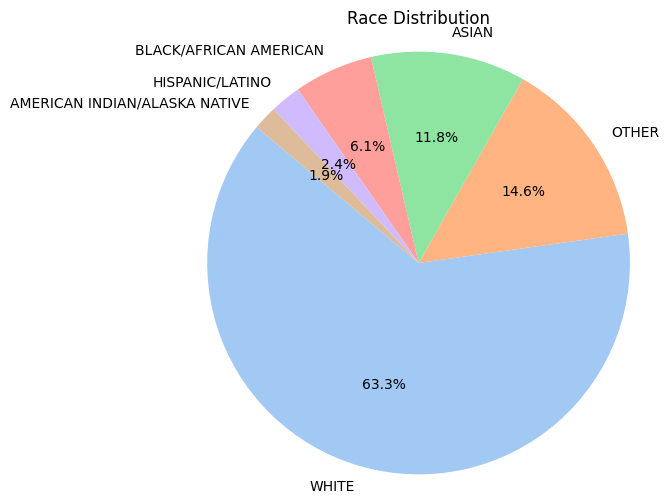

In [56]:
# Count the occurrences of each race
race_counts = data_df.race.value_counts()

# Define a Seaborn color palette with muted colors
sns.set_palette("pastel")

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Race Distribution')

# Show the pie chart
plt.axis('equal')
plt.show()

C:\Users\gebre\AppData\Local\Temp\ipykernel_10880\1176276377.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, x='age_decile', palette="pastel")


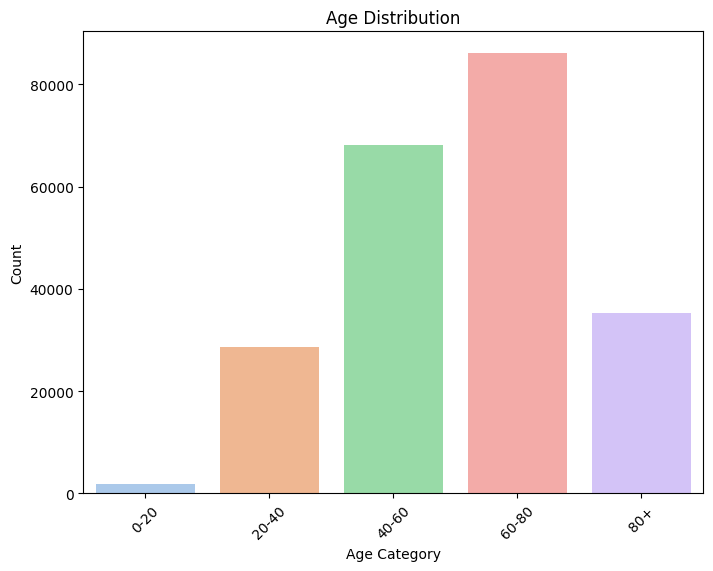

In [57]:
# Set a Seaborn style with muted colors
sns.set_palette("pastel")

# Create a count plot for age categories
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.countplot(data=data_df, x='age_decile', palette="pastel")
plt.title('Age Distribution')
plt.xlabel('Age Category')
plt.ylabel('Count')

# Show the count plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

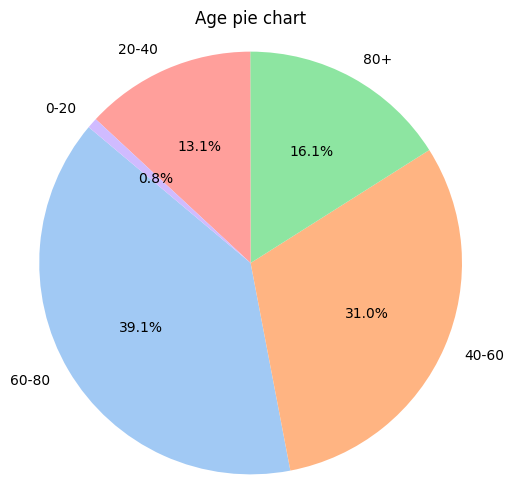

In [58]:
# Count the occurrences of each race
age_counts = data_df.age_decile.value_counts()

# Define a Seaborn color palette with muted colors
sns.set_palette("pastel")

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Age pie chart')

# Show the pie chart
plt.axis('equal')
plt.show()

In [59]:

data_df.to_csv(dataset_path+"CheXpert_Preprocessed.csv",index=False)

In [60]:
labels_Columns=['Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion',
                'Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax',
                'Pleural Effusion','Pleural Other','Fracture','Support Devices','No Finding']


In [61]:
df_train['features'][0]


array([-0.64997774, -2.12270832,  0.84318995, ..., -0.29365113,
        0.3868877 , -0.38179815])

In [62]:
# Create tf.data.Dataset objects for the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.features.values.tolist(), df_train[labels_Columns].values))

for train in train_dataset.take(2):
  print(train)

(<tf.Tensor: shape=(1376,), dtype=float64, numpy=
array([ 0.43689048, -1.98924041,  0.64045042, ..., -1.64703894,
        0.47789672, -1.65304232])>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.])>)
(<tf.Tensor: shape=(1376,), dtype=float64, numpy=
array([-0.69617951, -2.61596131,  0.33338141, ..., -0.6317538 ,
        0.59661829, -0.67676336])>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.])>)
